In [10]:
from __future__ import division, print_function, absolute_import
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Import MNIST data
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("../MNIST-data", False, one_hot=False)

Extracting ../MNIST-data/train-images-idx3-ubyte.gz
Extracting ../MNIST-data/train-labels-idx1-ubyte.gz
Extracting ../MNIST-data/t10k-images-idx3-ubyte.gz
Extracting ../MNIST-data/t10k-labels-idx1-ubyte.gz


In [3]:
# Training Parameters
learning_rate = 0.001
num_steps = 2000
batch_size = 128

# Network Parameters
num_input = 784 # MNIST data input (img shape: 28*28)
num_classes = 10 # MNIST total classes (0-9 digits)
dropout = 0.25 # Dropout, probability to drop a unit

In [4]:
# Create the neural network
def conv_net(x_dict, n_classes, dropout, reuse, is_training):
    # Define a scope for reusing the variables
    with tf.variable_scope('ConvNet', reuse=reuse):
        # TF Estimator input is a dict, in case of multiple inputs
        x = x_dict['images']

        # MNIST data input is a 1-D vector of 784 features (28*28 pixels)
        # Reshape to match picture format [Height x Width x Channel]
        # Tensor input become 4-D: [Batch Size, Height, Width, Channel]
        x = tf.reshape(x, shape=[-1, 28, 28, 1])

        # Convolution Layer with 32 filters and a kernel size of 5
        # 填充默认是'SAME'，24 = 28 - 5 + 1，深度为 32
        # 卷积操作使得图片变小，深度固定为指定大小
        conv1 = tf.layers.conv2d(x, 32, 5, activation=tf.nn.relu)  # (128, 24, 24, 32)
        # Max Pooling (down-sampling) with strides of 2 and kernel size of 2
        # 池化操作使得图片变小，深度不变
        conv1 = tf.layers.max_pooling2d(conv1, 2, 2)  # (128, 12, 12, 32)

        # Convolution Layer with 64 filters and a kernel size of 3
        conv2 = tf.layers.conv2d(conv1, 64, 3, activation=tf.nn.relu)  # (128, 10, 10, 64)
        # Max Pooling (down-sampling) with strides of 2 and kernel size of 2
        conv2 = tf.layers.max_pooling2d(conv2, 2, 2)  # (128, 5, 5, 64)

        # Flatten the data to a 1-D vector for the fully connected layer
        fc1 = tf.contrib.layers.flatten(conv2)  # (128, 1600)

        # Fully connected layer (in tf contrib folder for now)
        # tf.layers.dense函数改变fc1的最后一维为1024
        fc1 = tf.layers.dense(fc1, 1024)
        # Apply Dropout (if is_training is False, dropout is not applied)
        fc1 = tf.layers.dropout(fc1, rate=dropout, training=is_training)

        # Output layer, class prediction
        out = tf.layers.dense(fc1, n_classes)

    return out

In [5]:
# Define the model function (following TF Estimator Template)
def model_fn(features, labels, mode):
    # Build the neural network
    # Because Dropout have different behavior at training and prediction time, we
    # need to create 2 distinct computation graphs that still share the same weights.
    logits_train = conv_net(features, num_classes, dropout, reuse=False, is_training=True)
    logits_test = conv_net(features, num_classes, dropout, reuse=True, is_training=False)
    
    # Predictions
    pred_classes = tf.argmax(logits_test, axis=1)
    pred_probas = tf.nn.softmax(logits_test)
    
    # If prediction mode, early return
    if mode == tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(mode, predictions=pred_classes) 
        
    # Define loss and optimizer
    loss_op = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits_train,
                                                                            labels=tf.cast(labels, dtype=tf.int32)))
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
    train_op = optimizer.minimize(loss_op, global_step=tf.train.get_global_step())
    
    # Evaluate the accuracy of the model
    acc_op = tf.metrics.accuracy(labels=labels, predictions=pred_classes)
    
    # TF Estimators requires to return a EstimatorSpec, that specify
    # the different ops for training, evaluating, ...
    estim_specs = tf.estimator.EstimatorSpec(mode=mode,
                                             predictions=pred_classes,
                                             loss=loss_op,
                                             train_op=train_op,
                                             eval_metric_ops={'accuracy': acc_op})

    return estim_specs

In [6]:
# Build the Estimator
model = tf.estimator.Estimator(model_fn)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_keep_checkpoint_every_n_hours': 10000, '_save_summary_steps': 100, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fa94b000470>, '_keep_checkpoint_max': 5, '_session_config': None, '_tf_random_seed': None, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_task_id': 0, '_master': '', '_log_step_count_steps': 100, '_task_type': 'worker', '_service': None, '_model_dir': '/tmp/tmpoiujiiem', '_num_worker_replicas': 1, '_is_chief': True, '_num_ps_replicas': 0}


In [7]:
# Define the input function for training
input_fn = tf.estimator.inputs.numpy_input_fn(x={'images': mnist.train.images},
                                              y=mnist.train.labels,
                                              batch_size=batch_size,
                                              num_epochs=None,
                                              shuffle=True)
# Train the Model
model.train(input_fn, steps=num_steps)

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 1 into /tmp/tmpoiujiiem/model.ckpt.
INFO:tensorflow:loss = 2.30622, step = 1
INFO:tensorflow:global_step/sec: 4.25502
INFO:tensorflow:loss = 0.150477, step = 101 (23.506 sec)
INFO:tensorflow:global_step/sec: 4.25301
INFO:tensorflow:loss = 0.0628816, step = 201 (23.513 sec)
INFO:tensorflow:global_step/sec: 4.27238
INFO:tensorflow:loss = 0.0512142, step = 301 (23.405 sec)
INFO:tensorflow:global_step/sec: 4.29405
INFO:tensorflow:loss = 0.110709, step = 401 (23.287 sec)
INFO:tensorflow:global_step/sec: 4.27097
INFO:tensorflow:loss = 0.0152248, step = 501 (23.413 sec)
INFO:tensorflow:global_step/sec: 4.27514
INFO:tensorflow:loss = 0.00527779, step = 601 (23.392 sec)
INFO:tensorflow:global_step/sec: 4.28273
INFO:tensorflow:loss = 0.0419617, step = 701 (23.350 sec)
INFO:tensorflow:global_step/sec: 4.27917
INFO:tensorflow:loss = 0.0307672, step = 801 (23.368 sec)
INFO:tensorflow:global_step/sec: 4.27319
INFO:ten

In [8]:
# Evaluate the Model
# Define the input function for evaluating
input_fn = tf.estimator.inputs.numpy_input_fn(x={'images': mnist.test.images},
                                              y=mnist.test.labels,
                                              batch_size=batch_size,
                                              shuffle=False)
# Use the Estimator 'evaluate' method
model.evaluate(input_fn)

INFO:tensorflow:Starting evaluation at 2020-07-01-04:13:26
INFO:tensorflow:Restoring parameters from /tmp/tmpoiujiiem/model.ckpt-2000
INFO:tensorflow:Finished evaluation at 2020-07-01-04:13:32
INFO:tensorflow:Saving dict for global step 2000: accuracy = 0.9874, global_step = 2000, loss = 0.0406337


{'accuracy': 0.9874, 'global_step': 2000, 'loss': 0.040633701}

INFO:tensorflow:Restoring parameters from /tmp/tmpoiujiiem/model.ckpt-2000


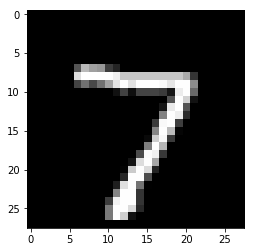

Model prediction: 7


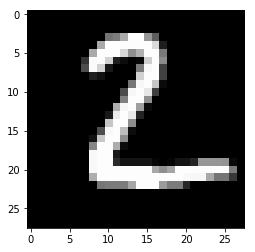

Model prediction: 2


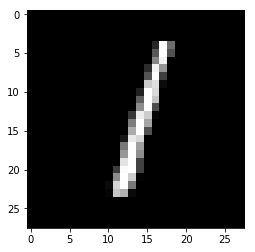

Model prediction: 1


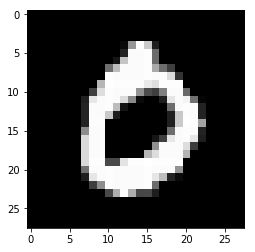

Model prediction: 0


In [9]:
# Predict single images
n_images = 4

# Get images from test set
test_images = mnist.test.images[:n_images]

# Prepare the input data
input_fn = tf.estimator.inputs.numpy_input_fn(x={'images': test_images},
                                              shuffle=False)

# Use the model to predict the images class
preds = list(model.predict(input_fn))

# Display
for i in range(n_images):
    plt.imshow(np.reshape(test_images[i], [28, 28]), cmap='gray')
    plt.show()
    print("Model prediction:", preds[i])